In [2]:
import numpy as np
import glob
import os
from tqdm import tqdm
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models

In [4]:
# 분산 전략 설정: GPU 수에 따라 설정
gpus = tf.config.list_physical_devices('GPU')
if len(gpus) >= 1:
    strategy = tf.distribute.MirroredStrategy(devices=["/gpu:0", "/gpu:1", "/gpu:2"])  # GPU 디바이스 번호에 맞게 수정
    print(f'사용 중인 디바이스 수: {strategy.num_replicas_in_sync}')
else:
    strategy = tf.distribute.MirroredStrategy()
    print(f'기본 전략 사용 중: {strategy.num_replicas_in_sync}')

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2')
사용 중인 디바이스 수: 3


### all landmark

In [5]:
# 메모리 매핑을 사용하여 데이터 로드
images = np.load('f_youtube_dataset_images.npy', mmap_mode='r')
landmarks = np.load('f_youtube_dataset_landmarks.npy', mmap_mode='r')

# limit개 샘플로 제한
limit = 100000
images_subset = images[:limit]
landmarks_subset = landmarks[:limit]

# 서브셋의 형태 출력
print(f'제한된 이미지 형태: {images_subset.shape}')         # 예: (limit, 224, 224, 3)
print(f'제한된 키포인트 형태: {landmarks_subset.shape}')   # 예: (limit, 68, 2)

제한된 이미지 형태: (100000, 224, 224, 3)
제한된 키포인트 형태: (100000, 68, 2)


데이터셋 배치, 프리페치 설정 완료.
배치 이미지 형태: (48, 224, 224, 3)
배치 키포인트 형태: (48, 136)


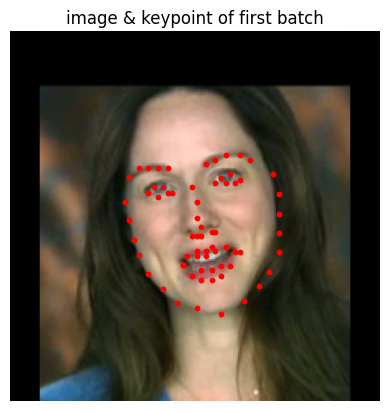

In [6]:
# 제너레이터 함수 정의 (개별 샘플 반환)
def data_generator(images, landmarks):
    num_samples = images.shape[0]
    indices = np.arange(num_samples)  # 섞지 않고 순서대로 데이터 인덱스를 가져옵니다.

    for idx in indices:
        image = images[idx].astype(np.float32) / 255.0  # 이미지 정규화 [0,1]
        landmark = landmarks[idx].astype(np.float32) / 224.0  # 키포인트 정규화 [0,1]
        landmark = landmark.reshape(-1)  # (68, 2) -> (136,)
        yield image, landmark

def generator():
    return data_generator(images, landmarks)

# TensorFlow 데이터셋 생성 (개별 샘플 반환)
output_signature = (
    tf.TensorSpec(shape=(224, 224, 3), dtype=tf.float32),
    tf.TensorSpec(shape=(136,), dtype=tf.float32)
)

dataset = tf.data.Dataset.from_generator(
    generator,
    output_signature=output_signature
)

# 데이터셋 배치, 프리페치 설정 (셔플 제거)
batch_size_per_replica = 16  # 각 GPU당 배치 사이즈
batch_size = batch_size_per_replica * strategy.num_replicas_in_sync  # 전체 배치 크기

dataset = dataset.batch(batch_size)
dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

print('데이터셋 배치, 프리페치 설정 완료.')

# 데이터셋 형태 확인 및 시각화
for batch_images, batch_landmarks in dataset.take(1):
    print('배치 이미지 형태:', batch_images.shape)         # (48, 224, 224, 3)
    print('배치 키포인트 형태:', batch_landmarks.shape)   # (48, 136)
    
    # 시각화 예시
    image = batch_images[0].numpy()
    landmarks_plot = batch_landmarks[0].numpy() * 224.0  # 정규화된 키포인트를 원래 크기로 복원

    plt.imshow(image)
    plt.scatter(landmarks_plot[::2], landmarks_plot[1::2], c='r', s=10)
    plt.title('image & keypoint of first batch')
    plt.axis('off')
    plt.show()


In [7]:
# 학습용과 검증용 데이터셋 분리
total_samples = 100000
train_ratio = 0.8
val_ratio = 0.2

train_size = int(train_ratio * total_samples)  
val_size = total_samples - train_size        

train_ds = dataset.take(train_size // batch_size)  
val_ds = dataset.skip(train_size // batch_size).take(val_size // batch_size)  

print(f'학습 데이터셋 배치 수: {train_size // batch_size}')  
print(f'검증 데이터셋 배치 수: {val_size // batch_size}')  

학습 데이터셋 배치 수: 1666
검증 데이터셋 배치 수: 416


In [11]:
from tensorflow.keras.callbacks import Callback, LearningRateScheduler, ModelCheckpoint, CSVLogger
import time

# 에포크 시간 측정을 위한 콜백 클래스 정의
class TimeHistory(Callback):
    def on_train_begin(self, logs=None):
        self.times = []

    def on_epoch_begin(self, epoch, logs=None):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, epoch, logs=None):
        self.times.append(time.time() - self.epoch_time_start)

time_callback = TimeHistory()
        
# 콜백 설정
checkpoint = ModelCheckpoint('y_all_v2_adam_10.h5', monitor='val_loss', save_best_only=True, verbose=1)
time_callback = TimeHistory()
csv_logger = CSVLogger('y_all_training_log_10.csv', append=True)

# **모델 훈련**

EPOCHS = 100

history = model.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=val_ds,
    callbacks=[checkpoint, time_callback, csv_logger]
)

Epoch 1/100
INFO:tensorflow:Collective all_reduce tensors: 162 all_reduces, num_devices = 3, group_size = 3, implementation = CommunicationImplementation.NCCL, num_packs = 1
INFO:tensorflow:Collective all_reduce tensors: 162 all_reduces, num_devices = 3, group_size = 3, implementation = CommunicationImplementation.NCCL, num_packs = 1


2024-11-13 02:34:29.527659: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8907
2024-11-13 02:34:29.540125: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8907
2024-11-13 02:34:29.555475: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8907
2024-11-13 02:34:32.586182: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fa78afaea80 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-11-13 02:34:32.586229: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
2024-11-13 02:34:32.586236: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
2024-11-13 02:34:32.586242: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (2): Tesla T4, Compute Capability 7.5
2024-11-13 02:34:32.595869: I ten

   1666/Unknown - 268s 119ms/step - loss: 0.0081 - mae: 0.0478

2024-11-13 02:38:03.267749: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10616108262282060096
2024-11-13 02:38:03.267832: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 11950803992808300502
2024-11-13 02:38:03.267893: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 8438321374242341870
2024-11-13 02:38:03.267903: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10073643301860778914
2024-11-13 02:38:03.267911: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 13949870767902803210
2024-11-13 02:38:03.267920: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10969744351852120118
2024-11-13 02:38:03.267928: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous rec


Epoch 1: val_loss improved from inf to 0.00388, saving model to y_all_v2_adam_10.h5


2024-11-13 02:39:15.397293: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 17407835744934433205
2024-11-13 02:39:15.397360: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 8260986068768170701
2024-11-13 02:39:15.397372: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6104453445494087174
2024-11-13 02:39:15.397415: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 14803213047053255598
2024-11-13 02:39:15.397428: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 13186445682468012447
2024-11-13 02:39:15.397461: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 10235791972248404879
2024-11-13 02:39:15.397473: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv

1666/1666 [==============================] - 342s 163ms/step - loss: 0.0081 - mae: 0.0478 - val_loss: 0.0039 - val_mae: 0.0493
Epoch 2/100
1666/1666 [==============================] - ETA: 0s - loss: 4.2915e-04 - mae: 0.0161
Epoch 2: val_loss improved from 0.00388 to 0.00065, saving model to y_all_v2_adam_10.h5
1666/1666 [==============================] - 265s 159ms/step - loss: 4.2915e-04 - mae: 0.0161 - val_loss: 6.5394e-04 - val_mae: 0.0200
Epoch 3/100
1666/1666 [==============================] - ETA: 0s - loss: 2.5880e-04 - mae: 0.0125
Epoch 3: val_loss improved from 0.00065 to 0.00039, saving model to y_all_v2_adam_10.h5
1666/1666 [==============================] - 265s 159ms/step - loss: 2.5880e-04 - mae: 0.0125 - val_loss: 3.9447e-04 - val_mae: 0.0155
Epoch 4/100
1666/1666 [==============================] - ETA: 0s - loss: 1.8880e-04 - mae: 0.0107
Epoch 4: val_loss improved from 0.00039 to 0.00038, saving model to y_all_v2_adam_10.h5
1666/1666 [==============================] - 

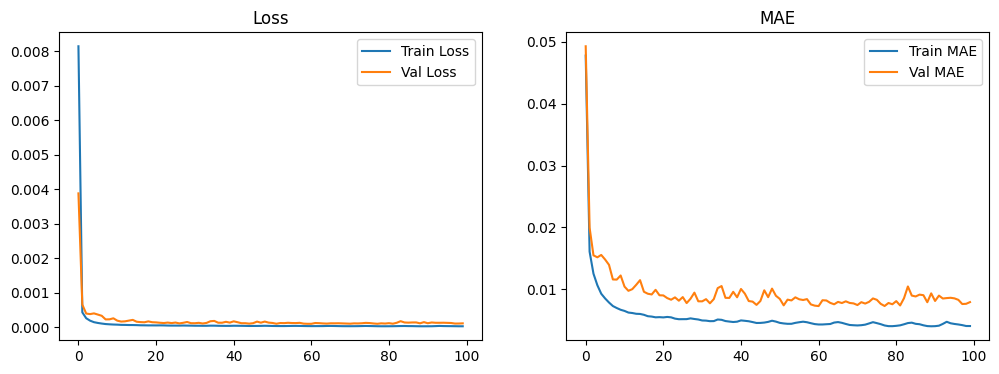

In [12]:
import matplotlib.pyplot as plt

# 훈련 손실 및 MAE 시각화
plt.figure(figsize=(12, 4))

# Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Loss')

# MAE
plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Val MAE')
plt.legend()
plt.title('MAE')

plt.show()

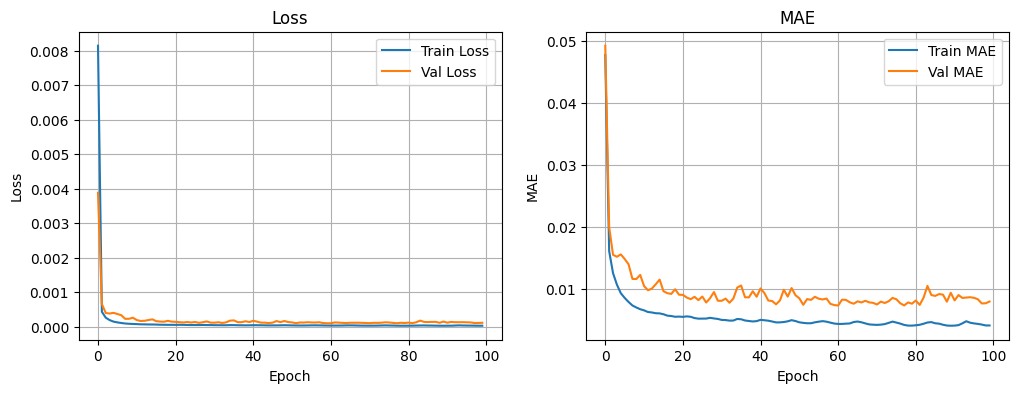

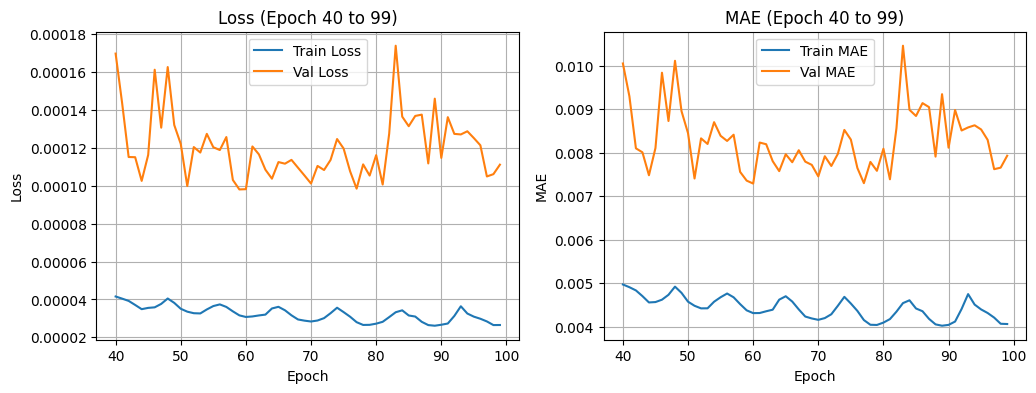

Best Epoch: 60
Minimum Validation Loss: 9.805766603676602e-05


In [10]:
import pandas as pd
import matplotlib.pyplot as plt

# CSV 파일 경로 설정
csv_file_path = 'csv_logger/y_all_training_log_10.csv'

# CSV 파일 읽기
history_df = pd.read_csv(csv_file_path)

# 에포크 수 가져오기
epochs = history_df['epoch']

# 전체 에포크 그래프 그리기
plt.figure(figsize=(12, 4))

# Loss 그래프
plt.subplot(1, 2, 1)
plt.plot(epochs, history_df['loss'], label='Train Loss')
plt.plot(epochs, history_df['val_loss'], label='Val Loss')
plt.legend()
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)

# MAE 그래프
plt.subplot(1, 2, 2)
plt.plot(epochs, history_df['mae'], label='Train MAE')
plt.plot(epochs, history_df['val_mae'], label='Val MAE')
plt.legend()
plt.title('MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.grid(True)

plt.show()

# 특정 에포크 범위 설정
start_epoch = 40  # 시작 에포크 (0부터 시작)
end_epoch = 100   # 끝 에포크 (포함하지 않음)

# 에포크 범위에 해당하는 인덱스 생성
epoch_range = (history_df['epoch'] >= start_epoch) & (history_df['epoch'] < end_epoch)

# 선택한 에포크 범위의 데이터 선택
selected_epochs = history_df['epoch'][epoch_range]
train_loss = history_df['loss'][epoch_range]
val_loss = history_df['val_loss'][epoch_range]
train_mae = history_df['mae'][epoch_range]
val_mae = history_df['val_mae'][epoch_range]

# 선택한 에포크 범위 그래프 그리기
plt.figure(figsize=(12, 4))

# Loss 그래프
plt.subplot(1, 2, 1)
plt.plot(selected_epochs, train_loss, label='Train Loss')
plt.plot(selected_epochs, val_loss, label='Val Loss')
plt.legend()
plt.title('Loss (Epoch {} to {})'.format(start_epoch, end_epoch - 1))
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)

# MAE 그래프
plt.subplot(1, 2, 2)
plt.plot(selected_epochs, train_mae, label='Train MAE')
plt.plot(selected_epochs, val_mae, label='Val MAE')
plt.legend()
plt.title('MAE (Epoch {} to {})'.format(start_epoch, end_epoch - 1))
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.grid(True)

plt.show()

min_val_loss = history_df['val_loss'].min()
best_epoch = history_df[history_df['val_loss'] == min_val_loss]['epoch'].values[0] + 1  # 1을 더해줍니다.
print(f"Best Epoch: {best_epoch}")
print(f"Minimum Validation Loss: {min_val_loss}")

테스트 이미지 형태: (160399, 224, 224, 3)
테스트 키포인트 형태: (160399, 68, 2)
모델이 성공적으로 로드되었습니다.
1/1 [==============================] - 1s 1s/step
평균 제곱 오차(MSE): 4.0156
평균 절대 오차(MAE): 1.5513
PCK@3px: 0.7059
PCK@5px: 0.9412
PCK@7px: 1.0000
PCK@10px: 1.0000


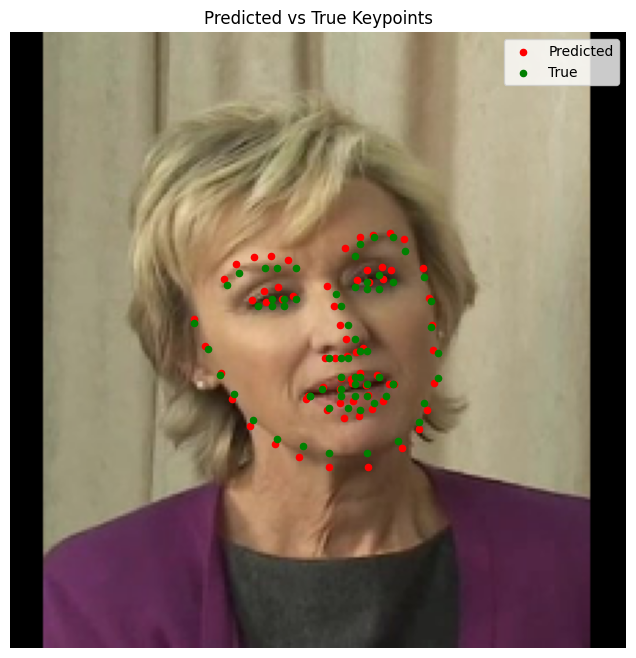

In [34]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error

# 1. 데이터 로드
# 메모리 매핑을 사용하여 데이터 로드
images = np.load('f_youtube_dataset_images.npy', mmap_mode='r')
landmarks = np.load('f_youtube_dataset_landmarks.npy', mmap_mode='r')

# limit개 샘플로 제한
limit = 100000
test_images = images[limit:]
test_landmarks = landmarks[limit:]

# 서브셋의 형태 출력
print(f'테스트 이미지 형태: {test_images.shape}')         # (총 샘플 수 - limit, 224, 224, 3)
print(f'테스트 키포인트 형태: {test_landmarks.shape}')   # (총 샘플 수 - limit, 68, 2)

# 2. 모델 로드
model_path = 'model_h5/y_all_v2_adam_10.h5'  # 모델 경로를 정확히 지정하세요
loaded_model = tf.keras.models.load_model(model_path)
print("모델이 성공적으로 로드되었습니다.")

# 3. 평가 함수 정의
def evaluate_single_image(model, image, true_keypoints, target_size=224, thresholds=[1, 3, 5, 7, 10]):
    """
    단일 이미지에 대해 모델의 예측을 수행하고, 평가 지표를 계산하며 시각화하는 함수.

    Parameters:
        model (tf.keras.Model): 사전 학습된 모델.
        image (np.ndarray): 평가할 이미지 (형태: (224, 224, 3)).
        true_keypoints (np.ndarray): 실제 키포인트 좌표 (1차원 배열, 길이 136).
        target_size (int): 모델의 입력 이미지 크기.
        thresholds (list): 거리 임계값들의 리스트 (픽셀 단위).
    """
    import matplotlib.pyplot as plt
    import numpy as np
    from sklearn.metrics import mean_squared_error, mean_absolute_error

    # 이미지 전처리 (이미지가 이미 (224, 224, 3)이고 [0, 255] 범위라고 가정)
    input_image = image.astype(np.float32) / 255.0
    input_image = np.expand_dims(input_image, axis=0)  # 배치 차원 추가

    # 예측
    predicted_keypoints = model.predict(input_image)[0]

    # 모델 출력이 [0,1] 범위이므로, 이를 [0, target_size]로 변환
    predicted_keypoints = predicted_keypoints * target_size

    # 실제 키포인트도 [0, target_size] 범위로 변환
    true_keypoints = true_keypoints * target_size

    # MSE 및 MAE 계산
    mse = mean_squared_error(true_keypoints, predicted_keypoints)
    mae = mean_absolute_error(true_keypoints, predicted_keypoints)

    print(f"평균 제곱 오차(MSE): {mse:.4f}")
    print(f"평균 절대 오차(MAE): {mae:.4f}")

    # 키포인트를 (num_keypoints, 2) 형태로 재구성
    num_keypoints = len(true_keypoints) // 2
    true_keypoints_reshaped = true_keypoints.reshape(-1, 2)
    predicted_keypoints_reshaped = predicted_keypoints.reshape(-1, 2)

    # 각 키포인트의 유클리드 거리 계산
    distances = np.linalg.norm(true_keypoints_reshaped - predicted_keypoints_reshaped, axis=1)

    # 여러 임계값에 대한 PCK 계산
    for threshold in thresholds:
        num_correct_keypoints = np.sum(distances <= threshold)
        pck = num_correct_keypoints / num_keypoints
        print(f"PCK@{threshold}px: {pck:.4f}")

    # 키포인트 시각화
    plt.figure(figsize=(8, 8))
    plt.imshow(image.astype(np.uint8))

    # 예측 키포인트
    plt.scatter(predicted_keypoints_reshaped[:, 0], predicted_keypoints_reshaped[:, 1], c='r', s=20, label='Predicted')
    # 실제 키포인트
    plt.scatter(true_keypoints_reshaped[:, 0], true_keypoints_reshaped[:, 1], c='g', s=20, label='True')

    plt.title('Predicted vs True Keypoints')
    plt.legend()
    plt.axis('off')
    plt.show()

# 4. 데이터셋에서 샘플 선택
sample_index = 101310  # 원하는 인덱스로 변경 가능
sample_image = test_images[sample_index]
sample_keypoints = test_landmarks[sample_index].reshape(-1) / 224.0  # [0, 1]로 정규화

# 5. 평가 및 시각화 수행
evaluate_single_image(
    loaded_model,
    sample_image,
    sample_keypoints,
    target_size=224,
    thresholds=[3, 5, 7, 10]
)


In [26]:
def evaluate_multiple_images(model, images, keypoints, target_size=224, thresholds=[1, 3, 5, 7, 10], num_samples=100):
    pck_values = {th: [] for th in thresholds}
    mse_list = []
    mae_list = []

    for i in range(num_samples):
        image = images[i]
        true_keypoint = keypoints[i].reshape(-1) / 224.0  # [0, 1]로 정규화

        # 이미지 전처리
        input_image = image.astype(np.float32) / 255.0
        input_image = np.expand_dims(input_image, axis=0)

        # 예측
        predicted_keypoint = model.predict(input_image)[0]
        predicted_keypoint = predicted_keypoint * target_size
        true_keypoint = true_keypoint * target_size

        # MSE 및 MAE 계산
        mse = mean_squared_error(true_keypoint, predicted_keypoint)
        mae = mean_absolute_error(true_keypoint, predicted_keypoint)
        mse_list.append(mse)
        mae_list.append(mae)

        # 키포인트 재구성
        num_keypoints = len(true_keypoint) // 2
        true_keypoints_reshaped = true_keypoint.reshape(-1, 2)
        predicted_keypoints_reshaped = predicted_keypoint.reshape(-1, 2)

        # 거리 오차 계산
        distances = np.linalg.norm(true_keypoints_reshaped - predicted_keypoints_reshaped, axis=1)

        # PCK 계산
        for threshold in thresholds:
            num_correct_keypoints = np.sum(distances <= threshold)
            pck = num_correct_keypoints / num_keypoints
            pck_values[threshold].append(pck)

    # 평균 지표 계산
    avg_mse = np.mean(mse_list)
    avg_mae = np.mean(mae_list)
    print(f"평균 MSE: {avg_mse:.4f}")
    print(f"평균 MAE: {avg_mae:.4f}")

    for threshold in thresholds:
        avg_pck = np.mean(pck_values[threshold])
        print(f"평균 PCK@{threshold}px: {avg_pck:.4f}")

# 함수 호출
evaluate_multiple_images(
    loaded_model,
    test_images,
    test_landmarks,
    target_size=224,
    thresholds=[1, 3, 5, 7, 10],
    num_samples=100  # 평가할 샘플 수
)


1/1 [==============================] - 0s 43ms/step
평균 MSE: 4.0925
평균 MAE: 1.5642
평균 PCK@1px: 0.1371
평균 PCK@3px: 0.7076
평균 PCK@5px: 0.9385
평균 PCK@7px: 0.9897
평균 PCK@10px: 0.9990


In [8]:
from tensorflow.keras.callbacks import Callback, ModelCheckpoint, CSVLogger, ReduceLROnPlateau
import time
from tensorflow.keras import layers, models

# 분산 전략 내에서 모델 정의 및 컴파일
with strategy.scope():
    # 3. 모델 로드
    model = tf.keras.models.load_model('model_h5/y_all_v2_adam_10.h5')
    
    # 4. 모델 컴파일
    # 옵티마이저, 손실 함수, 평가 지표를 정의합니다.
    model.compile(
        optimizer=tf.keras.optimizers.RMSprop(learning_rate=1e-3),
        loss='mse',
        metrics=['mae']
    )
    
    # 5. 콜백 설정
    checkpoint = ModelCheckpoint('v2_rmsprop_all_10.h5', monitor='val_loss', save_best_only=True, verbose=1)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=15, verbose=1)
    csv_logger = CSVLogger('v2_rmsprop_all_10.csv', append=True)
    
    # 6. 배치 사이즈 설정
    per_replica_batch_size = 16
    GLOBAL_BATCH_SIZE = per_replica_batch_size * strategy.num_replicas_in_sync
    
    # 7. 모델 훈련
    EPOCHS = 50
    
    history = model.fit(
        train_ds, 
        epochs=EPOCHS,
        validation_data=val_ds,
        callbacks=[checkpoint, reduce_lr, csv_logger]
    )

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Redu

2024-11-18 05:59:12.723612: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8907
2024-11-18 05:59:12.744796: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8907
2024-11-18 05:59:12.762412: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8907
2024-11-18 05:59:13.307710: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 201.64MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-11-18 05:59:13.312466: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 16.00MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-11-18 05:59:13.312548: W tensorf

NotFoundError: Graph execution error:

Detected at node model_1/block_3_project/Conv2D defined at (most recent call last):
  File "/usr/lib/python3.10/threading.py", line 973, in _bootstrap

  File "/usr/lib/python3.10/threading.py", line 1016, in _bootstrap_inner

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1349, in run_step

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1126, in train_step

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 589, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/base_layer.py", line 1149, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py", line 515, in call

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py", line 672, in _run_internal_graph

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/base_layer.py", line 1149, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py", line 290, in call

  File "/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py", line 262, in convolution_op

Detected at node model_1/block_3_project/Conv2D defined at (most recent call last):
  File "/usr/lib/python3.10/threading.py", line 973, in _bootstrap

  File "/usr/lib/python3.10/threading.py", line 1016, in _bootstrap_inner

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1349, in run_step

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1126, in train_step

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 589, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/base_layer.py", line 1149, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py", line 515, in call

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py", line 672, in _run_internal_graph

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/base_layer.py", line 1149, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py", line 290, in call

  File "/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py", line 262, in convolution_op

Detected at node model_1/block_3_project/Conv2D defined at (most recent call last):
  File "/usr/lib/python3.10/threading.py", line 973, in _bootstrap

  File "/usr/lib/python3.10/threading.py", line 1016, in _bootstrap_inner

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1349, in run_step

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1126, in train_step

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 589, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/base_layer.py", line 1149, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py", line 515, in call

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py", line 672, in _run_internal_graph

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/base_layer.py", line 1149, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py", line 290, in call

  File "/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py", line 262, in convolution_op

Detected at node model_1/block_3_project/Conv2D defined at (most recent call last):
  File "/usr/lib/python3.10/threading.py", line 973, in _bootstrap

  File "/usr/lib/python3.10/threading.py", line 1016, in _bootstrap_inner

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1349, in run_step

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1126, in train_step

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 589, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/base_layer.py", line 1149, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py", line 515, in call

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py", line 672, in _run_internal_graph

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/base_layer.py", line 1149, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py", line 290, in call

  File "/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py", line 262, in convolution_op

4 root error(s) found.
  (0) NOT_FOUND:  No algorithm worked!  Error messages:
  Profiling failure on CUDNN engine eng1{}: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 16777792 bytes.
  Profiling failure on CUDNN engine eng28{}: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 16777216 bytes.
  Profiling failure on CUDNN engine eng0{}: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 16777216 bytes.
	 [[{{node model_1/block_3_project/Conv2D}}]]
	 [[div_no_nan/_513]]
	 [[div_no_nan_1/ReadVariableOp/_472]]
	 [[group_deps/_525]]
  (1) NOT_FOUND:  No algorithm worked!  Error messages:
  Profiling failure on CUDNN engine eng1{}: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 16777792 bytes.
  Profiling failure on CUDNN engine eng28{}: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 16777216 bytes.
  Profiling failure on CUDNN engine eng0{}: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 16777216 bytes.
	 [[{{node model_1/block_3_project/Conv2D}}]]
	 [[div_no_nan/_513]]
	 [[div_no_nan_1/ReadVariableOp/_472]]
  (2) NOT_FOUND:  No algorithm worked!  Error messages:
  Profiling failure on CUDNN engine eng1{}: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 16777792 bytes.
  Profiling failure on CUDNN engine eng28{}: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 16777216 bytes.
  Profiling failure on CUDNN engine eng0{}: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 16777216 bytes.
	 [[{{node model_1/block_3_project/Conv2D}}]]
	 [[div_no_nan/_513]]
  (3) NOT_FOUND:  No algorithm worked!  Error messages:
  Profiling failure on CUDNN engine eng1{}: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 16777792 bytes.
  Profiling failure on CUDNN engine eng28{}: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 16777216 bytes.
  Profiling failure on CUDNN engine eng0{}: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 16777216 bytes.
	 [[{{node model_1/block_3_project/Conv2D}}]]
0 successful operations.
0 derived errors ignored. [Op:__inference_train_function_63779]